In [1]:
# Import Required Libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import json
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ All libraries imported successfully!")
print(f"Device: {device}")

✓ All libraries imported successfully!
Device: cuda


## 1. Load Best Models and Results

In [2]:
# Load results from each model's directory
results_dirs = {
    'SimpleNN': 'simplenn_results',
    'MLP': 'mlp_results',
    'CNN': 'cnn_results',
    'Transfer Learning': 'transfer_learning_results'
}

# Function to load the most recent summary report
def load_latest_summary(results_dir):
    """Load the most recent summary report from results directory"""
    try:
        # Find all summary_report files
        files = [f for f in os.listdir(results_dir) if f.startswith('summary_report_')]
        if not files:
            print(f"  ✗ No summary reports found in {results_dir}")
            return None
        
        # Sort by timestamp (most recent first)
        latest_file = sorted(files, reverse=True)[0]
        
        with open(os.path.join(results_dir, latest_file), 'r') as f:
            summary = json.load(f)
        return summary
    except Exception as e:
        print(f"  ✗ Error loading summary from {results_dir}: {e}")
        return None

# Load all summaries
print("Loading model results...\n")
all_summaries = {}
for model_name, results_dir in results_dirs.items():
    print(f"  Loading {model_name}...")
    summary = load_latest_summary(results_dir)
    if summary:
        all_summaries[model_name] = summary
        print(f"    ✓ Val Acc: {summary['best_val_accuracy']:.4f}, Test Acc: {summary['best_test_accuracy']:.4f}")
    else:
        print(f"    ✗ Failed to load")

print(f"\n✓ Successfully loaded {len(all_summaries)}/4 models")

Loading model results...

  Loading SimpleNN...
    ✓ Val Acc: 0.5156, Test Acc: 0.5038
  Loading MLP...
    ✓ Val Acc: 0.7315, Test Acc: 0.7270
  Loading CNN...
    ✓ Val Acc: 0.9751, Test Acc: 0.9709
  Loading Transfer Learning...
    ✓ Val Acc: 0.9397, Test Acc: 0.9386

✓ Successfully loaded 4/4 models


## 2. Performance Comparison Table

In [3]:
# Create comparison DataFrame
comparison_data = []
for model_name, summary in all_summaries.items():
    comparison_data.append({
        'Model': model_name,
        'Val Accuracy': summary['best_val_accuracy'],
        'Test Accuracy': summary['best_test_accuracy'],
        'Tuning Combinations': summary['total_combinations'],
        'Top 5 Mean Val Acc': np.mean(summary['top5_accuracies']),
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Test Accuracy', ascending=False)

print("\n" + "="*80)
print("INTER-MODEL COMPARISON".center(80))
print("="*80)
print("\nPerformance Metrics (sorted by Test Accuracy):")
print(comparison_df.to_string(index=False))
print("="*80)


                             INTER-MODEL COMPARISON                             

Performance Metrics (sorted by Test Accuracy):
            Model  Val Accuracy  Test Accuracy  Tuning Combinations  Top 5 Mean Val Acc
              CNN      0.975096       0.970893                  288            0.973974
Transfer Learning      0.939670       0.938629                   16            0.933532
              MLP      0.731498       0.726986                  648            0.705016
         SimpleNN      0.515609       0.503770                   72            0.510382


## 3. Best Hyperparameters Comparison

In [4]:
# Display best hyperparameters for each model
print("\n" + "="*80)
print("BEST HYPERPARAMETERS BY MODEL".center(80))
print("="*80)

for model_name, summary in all_summaries.items():
    print(f"\n{model_name}:")
    print("-" * 80)
    print(f"  Best Validation Accuracy: {summary['best_val_accuracy']:.4f}")
    print(f"  Best Test Accuracy: {summary['best_test_accuracy']:.4f}")
    print(f"  \n  Hyperparameters:")
    for key, value in summary['best_hyperparameters'].items():
        print(f"    {key}: {value}")

print("\n" + "="*80)


                         BEST HYPERPARAMETERS BY MODEL                          

SimpleNN:
--------------------------------------------------------------------------------
  Best Validation Accuracy: 0.5156
  Best Test Accuracy: 0.5038
  
  Hyperparameters:
    learning_rate: 0.001
    batch_size: 128
    num_epochs: 30
    optimizer: adam

MLP:
--------------------------------------------------------------------------------
  Best Validation Accuracy: 0.7315
  Best Test Accuracy: 0.7270
  
  Hyperparameters:
    learning_rate: 0.001
    batch_size: 64
    hidden_sizes: [256, 128]
    dropout: 0.1
    num_epochs: 30
    optimizer: adam

CNN:
--------------------------------------------------------------------------------
  Best Validation Accuracy: 0.9751
  Best Test Accuracy: 0.9709
  
  Hyperparameters:
    learning_rate: 0.001
    batch_size: 128
    kernel_size: 5
    padding: 1
    num_epochs: 30
    optimizer: adam

Transfer Learning:
-------------------------------------------

## 4. Accuracy Comparison Visualizations

✓ Comparison plot saved as 'inter_model_comparison.png'


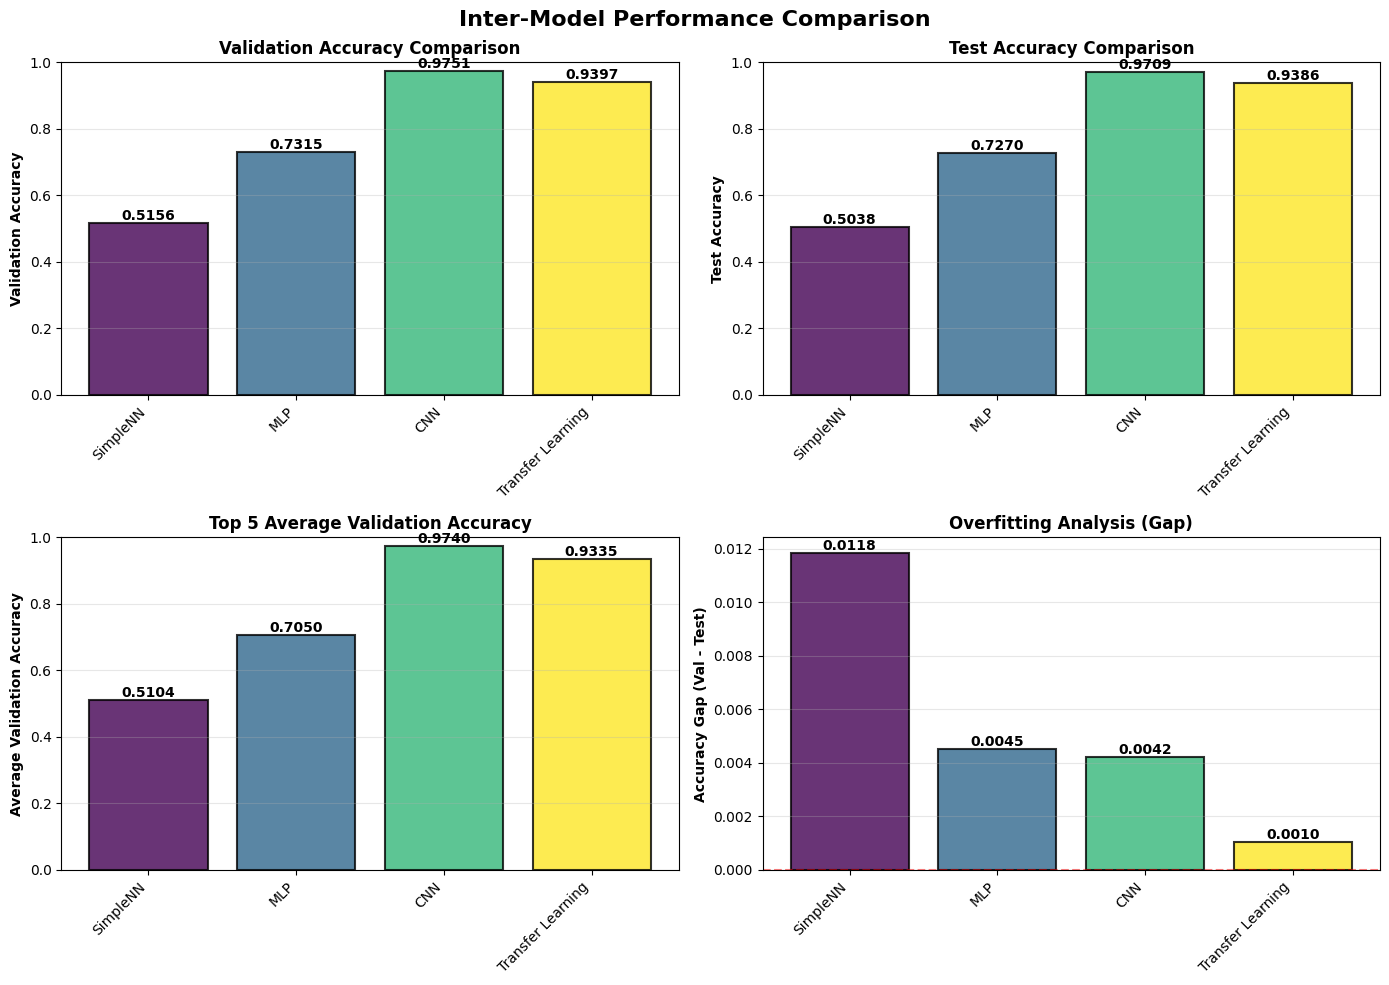

In [5]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Inter-Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. Validation Accuracy Comparison
ax = axes[0, 0]
models = list(all_summaries.keys())
val_accs = [all_summaries[m]['best_val_accuracy'] for m in models]
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
bars1 = ax.bar(models, val_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Validation Accuracy', fontweight='bold')
ax.set_title('Validation Accuracy Comparison', fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')
for bar, acc in zip(bars1, val_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Test Accuracy Comparison
ax = axes[0, 1]
test_accs = [all_summaries[m]['best_test_accuracy'] for m in models]
bars2 = ax.bar(models, test_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Test Accuracy', fontweight='bold')
ax.set_title('Test Accuracy Comparison', fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')
for bar, acc in zip(bars2, test_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Top 5 Average Validation Accuracy
ax = axes[1, 0]
top5_avgs = [np.mean(all_summaries[m]['top5_accuracies']) for m in models]
bars3 = ax.bar(models, top5_avgs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Average Validation Accuracy', fontweight='bold')
ax.set_title('Top 5 Average Validation Accuracy', fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')
for bar, avg in zip(bars3, top5_avgs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{avg:.4f}', ha='center', va='bottom', fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Accuracy Gap (Val - Test)
ax = axes[1, 1]
gaps = [all_summaries[m]['best_val_accuracy'] - all_summaries[m]['best_test_accuracy'] for m in models]
bars4 = ax.bar(models, gaps, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Accuracy Gap (Val - Test)', fontweight='bold')
ax.set_title('Overfitting Analysis (Gap)', fontweight='bold')
ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')
for bar, gap in zip(bars4, gaps):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{gap:.4f}', ha='center', va='bottom' if gap >= 0 else 'top', fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('inter_model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Comparison plot saved as 'inter_model_comparison.png'")
plt.show()

## 5. Loss Curve Comparison

In [6]:
# Function to load training history
def load_best_history(results_dir):
    """Load the best model's training history"""
    try:
        files = [f for f in os.listdir(results_dir) if f.startswith('best_model_history_')]
        if not files:
            return None
        latest_file = sorted(files, reverse=True)[0]
        with open(os.path.join(results_dir, latest_file), 'rb') as f:
            history = pickle.load(f)
        return history
    except Exception as e:
        print(f"Error loading history from {results_dir}: {e}")
        return None

# Load histories for all models
print("\nLoading training histories...")
histories = {}
for model_name, results_dir in results_dirs.items():
    history = load_best_history(results_dir)
    if history:
        histories[model_name] = history
        print(f"  ✓ {model_name}: {len(history['train_loss'])} epochs")
    else:
        print(f"  ✗ {model_name}: Failed to load")

print(f"\n✓ Successfully loaded {len(histories)}/4 histories")


Loading training histories...
  ✓ SimpleNN: 30 epochs
  ✓ MLP: 30 epochs
  ✓ CNN: 21 epochs
  ✓ Transfer Learning: 10 epochs

✓ Successfully loaded 4/4 histories


✓ Loss curves plot saved as 'loss_curves_all_models.png'


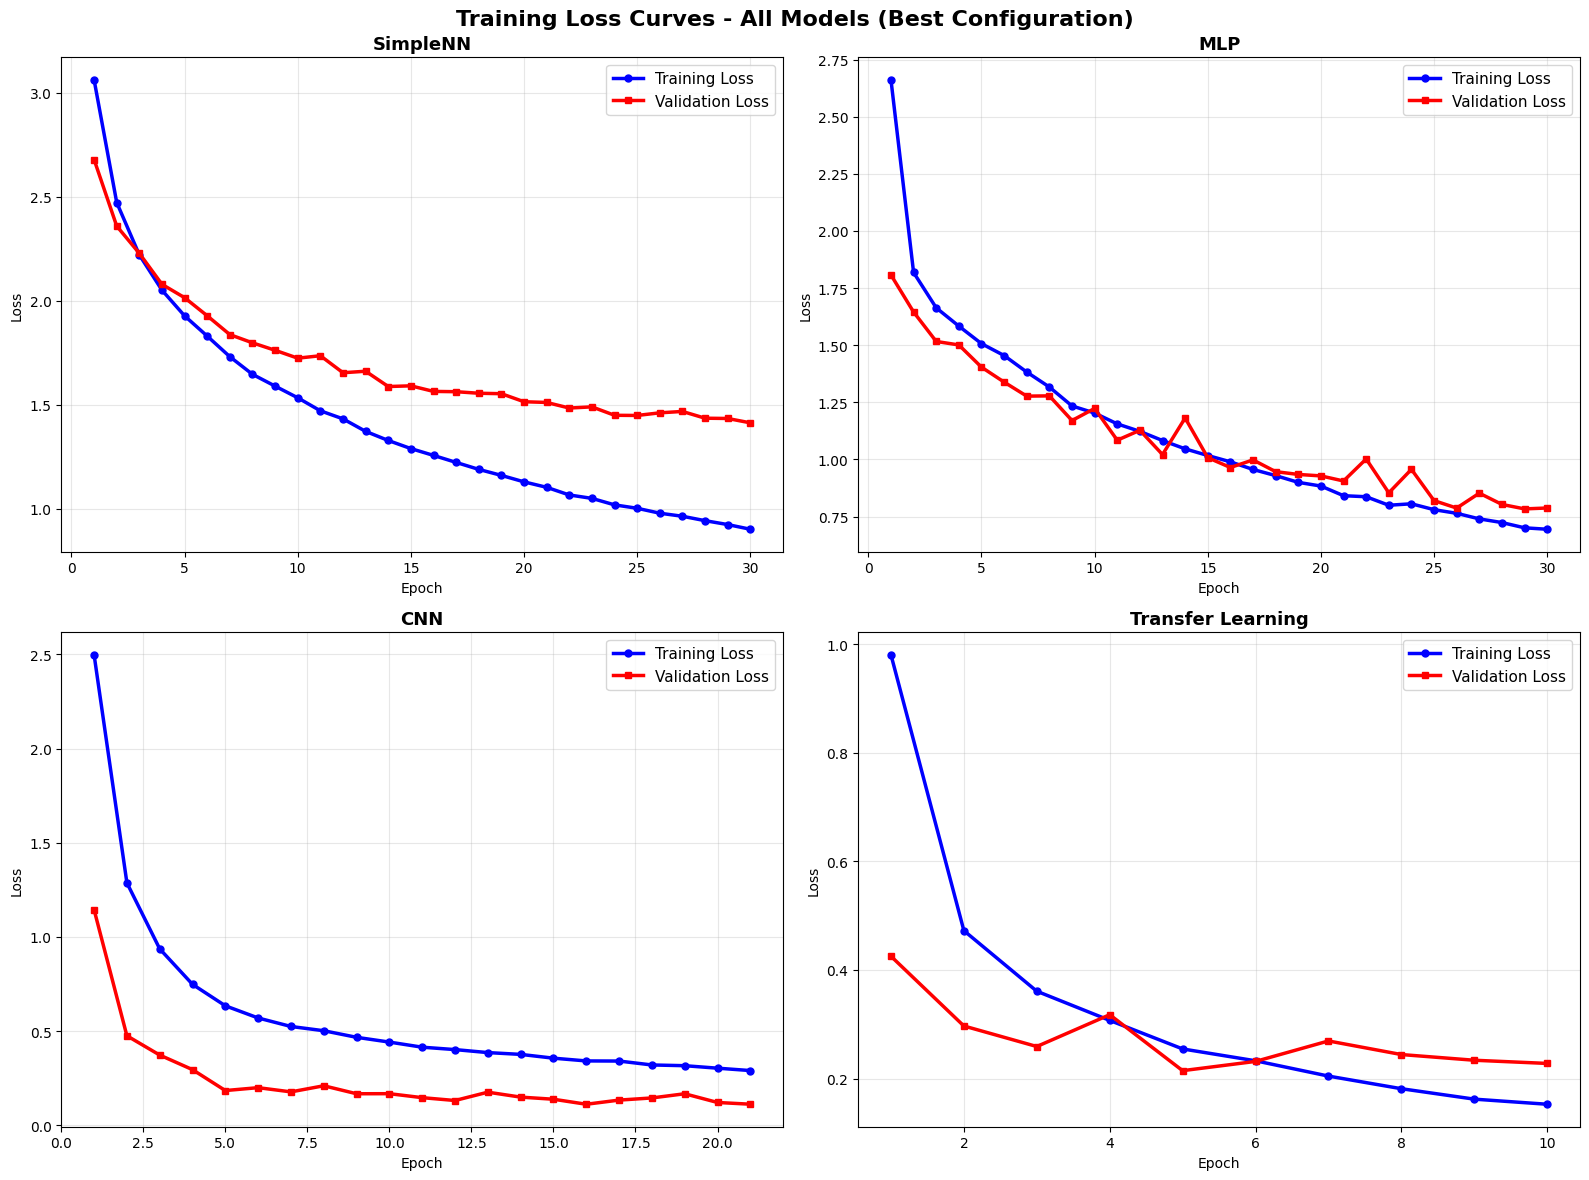

In [7]:
# Plot training loss curves for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training Loss Curves - All Models (Best Configuration)', fontsize=16, fontweight='bold')

model_names = list(histories.keys())
colors_loss = ['blue', 'green', 'red', 'purple']

# Individual plots for each model
for idx, (model_name, history) in enumerate(histories.items()):
    ax = axes[idx // 2, idx % 2]
    
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2.5, marker='o', markersize=5)
    ax.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2.5, marker='s', markersize=5)
    
    ax.set_title(f'{model_name}', fontweight='bold', fontsize=13)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_curves_all_models.png', dpi=300, bbox_inches='tight')
print("✓ Loss curves plot saved as 'loss_curves_all_models.png'")
plt.show()

✓ Normalized loss curves plot saved as 'loss_curves_comparison_normalized.png'


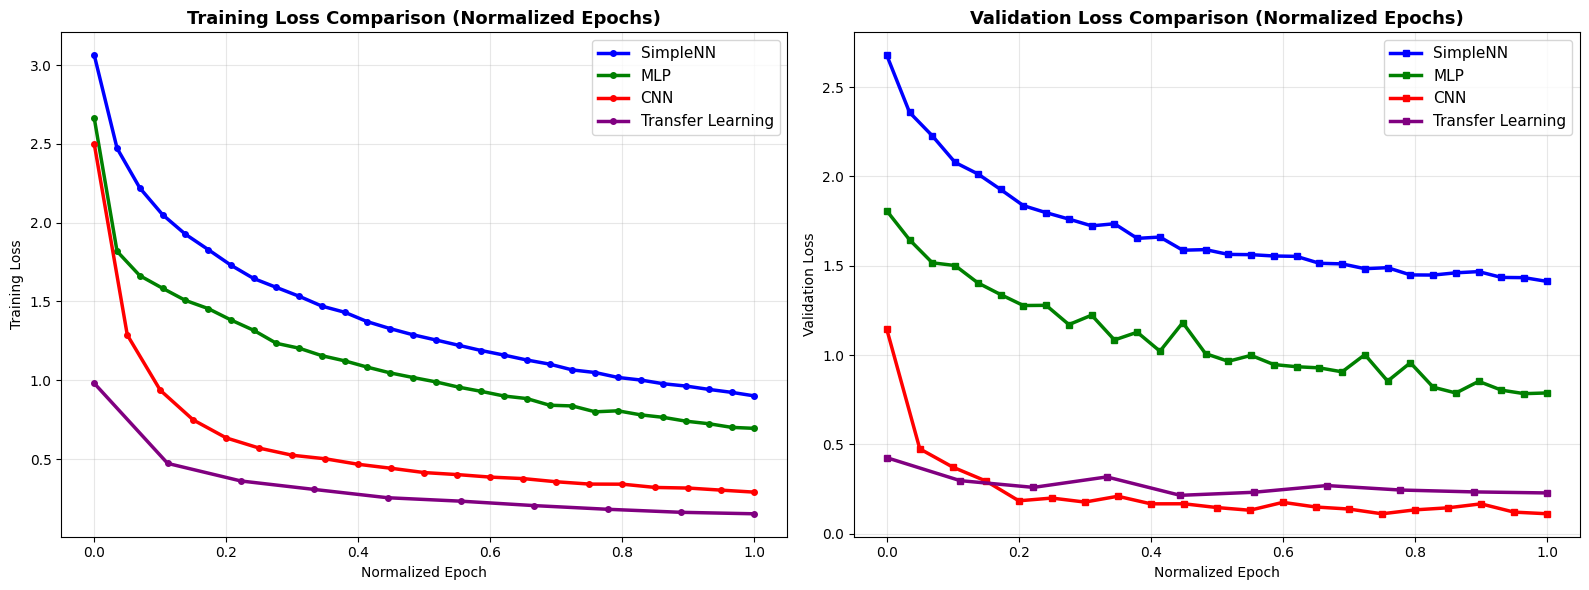

In [8]:
# Plot overlaid loss curves for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Normalize epochs to 0-1 for comparison (since models train for different durations)
colors_map = {'SimpleNN': 'blue', 'MLP': 'green', 'CNN': 'red', 'Transfer Learning': 'purple'}

# Training Loss
for model_name, history in histories.items():
    epochs_normalized = np.linspace(0, 1, len(history['train_loss']))
    ax1.plot(epochs_normalized, history['train_loss'], label=model_name, 
             color=colors_map.get(model_name, 'black'), linewidth=2.5, marker='o', markersize=4)

ax1.set_title('Training Loss Comparison (Normalized Epochs)', fontweight='bold', fontsize=13)
ax1.set_xlabel('Normalized Epoch')
ax1.set_ylabel('Training Loss')
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)

# Validation Loss
for model_name, history in histories.items():
    epochs_normalized = np.linspace(0, 1, len(history['val_loss']))
    ax2.plot(epochs_normalized, history['val_loss'], label=model_name, 
             color=colors_map.get(model_name, 'black'), linewidth=2.5, marker='s', markersize=4)

ax2.set_title('Validation Loss Comparison (Normalized Epochs)', fontweight='bold', fontsize=13)
ax2.set_xlabel('Normalized Epoch')
ax2.set_ylabel('Validation Loss')
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_curves_comparison_normalized.png', dpi=300, bbox_inches='tight')
print("✓ Normalized loss curves plot saved as 'loss_curves_comparison_normalized.png'")
plt.show()

## 6. Final Ranking and Recommendations

In [9]:
# Create final ranking
print("\n" + "="*80)
print("FINAL RANKING - BEST TO WORST".center(80))
print("="*80)

ranking = comparison_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)
ranking['Rank'] = range(1, len(ranking) + 1)

print("\n" + ranking[['Rank', 'Model', 'Val Accuracy', 'Test Accuracy', 'Top 5 Mean Val Acc']].to_string(index=False))

print("\n" + "="*80)
print("RECOMMENDATIONS".center(80))
print("="*80)

best_model = ranking.iloc[0]
print(f"\n🏆 BEST OVERALL MODEL: {best_model['Model']}")
print(f"   - Test Accuracy: {best_model['Test Accuracy']:.4f}")
print(f"   - Validation Accuracy: {best_model['Val Accuracy']:.4f}")
print(f"   - Recommendation: Use this model for production deployment")

# Check for overfitting
gaps = comparison_df.copy()
gaps['Gap'] = gaps['Val Accuracy'] - gaps['Test Accuracy']
best_generalization = gaps.sort_values('Gap').iloc[0]

print(f"\n💪 BEST GENERALIZATION (Lowest Overfitting): {best_generalization['Model']}")
print(f"   - Val-Test Gap: {best_generalization['Gap']:.4f}")
print(f"   - Recommendation: More robust to unseen data")

# Most efficient
efficient = ranking.sort_values('Tuning Combinations').iloc[0]
print(f"\n⚡ MOST EFFICIENT: {efficient['Model']}")
print(f"   - Tuning Combinations: {int(efficient['Tuning Combinations'])}")
print(f"   - Test Accuracy: {efficient['Test Accuracy']:.4f}")
print(f"   - Recommendation: Faster tuning process")

print("\n" + "="*80)


                         FINAL RANKING - BEST TO WORST                          

 Rank             Model  Val Accuracy  Test Accuracy  Top 5 Mean Val Acc
    1               CNN      0.975096       0.970893            0.973974
    2 Transfer Learning      0.939670       0.938629            0.933532
    3               MLP      0.731498       0.726986            0.705016
    4          SimpleNN      0.515609       0.503770            0.510382

                                RECOMMENDATIONS                                 

🏆 BEST OVERALL MODEL: CNN
   - Test Accuracy: 0.9709
   - Validation Accuracy: 0.9751
   - Recommendation: Use this model for production deployment

💪 BEST GENERALIZATION (Lowest Overfitting): Transfer Learning
   - Val-Test Gap: 0.0010
   - Recommendation: More robust to unseen data

⚡ MOST EFFICIENT: Transfer Learning
   - Tuning Combinations: 16
   - Test Accuracy: 0.9386
   - Recommendation: Faster tuning process



## 7. Summary Report

In [10]:
# Save comprehensive comparison report
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
report = {
    'timestamp': timestamp,
    'comparison': comparison_df.to_dict('records'),
    'best_model': {
        'name': best_model['Model'],
        'test_accuracy': float(best_model['Test Accuracy']),
        'val_accuracy': float(best_model['Val Accuracy']),
        'hyperparameters': all_summaries[best_model['Model']]['best_hyperparameters']
    },
    'all_model_details': {model: summary for model, summary in all_summaries.items()}
}

with open(f'inter_model_comparison_report_{timestamp}.json', 'w') as f:
    json.dump(report, f, indent=4, default=str)

print(f"\n✓ Comprehensive comparison report saved to: inter_model_comparison_report_{timestamp}.json")

# Save comparison table as CSV
comparison_df.to_csv(f'inter_model_comparison_{timestamp}.csv', index=False)
print(f"✓ Comparison table saved to: inter_model_comparison_{timestamp}.csv")

print(f"\n{'='*80}")
print("INTER-MODEL COMPARISON COMPLETE!".center(80))
print(f"{'='*80}")


✓ Comprehensive comparison report saved to: inter_model_comparison_report_20251126_213121.json
✓ Comparison table saved to: inter_model_comparison_20251126_213121.csv

                        INTER-MODEL COMPARISON COMPLETE!                        


## 5. Class-wise Classification Reports & Confusion Matrices

In [11]:
# Load data and best models for evaluation
import sys
sys.path.insert(0, os.getcwd())

from data_loading import WaferDataLoader
from models import SimpleNN, MLP, WaferCNN, WaferResNet18  # Updated to ResNet18
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

print("Loading dataset and best models...\n")

# Load data
loader = WaferDataLoader()
X = loader.X.astype('float32')
y = loader.y

# Normalize
X_min, X_max = X.min(), X.max()
X_normalized = (X - X_min) / (X_max - X_min) if X_max > X_min else X

# Prepare data for each model type
X_flat = X_normalized.reshape(X_normalized.shape[0], -1)  # Flattened for SimpleNN/MLP
X_2d = X_normalized.reshape(-1, 52, 52)  # 2D for CNN
X_3ch = np.repeat(X_2d[:, np.newaxis, :, :], 3, axis=1)  # 3-channel for Transfer Learning

# Split data
from sklearn.model_selection import train_test_split
X_train_flat, X_temp_flat, y_train, y_temp = train_test_split(
    X_flat, y, test_size=0.3, random_state=42, stratify=y
)
X_val_flat, X_test_flat, y_val, y_test = train_test_split(
    X_temp_flat, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Use same split indices as flat data to ensure consistency
X_train_2d, X_temp_2d, _, _ = train_test_split(
    X_2d, y, test_size=0.3, random_state=42, stratify=y
)
X_val_2d, X_test_2d, _, _ = train_test_split(
    X_temp_2d, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Add channel dimension for CNN: (N, 52, 52) -> (N, 1, 52, 52)
X_test_2d = X_test_2d[:, np.newaxis, :, :]

# Use same split indices as other data to ensure consistency
X_train_3ch, X_temp_3ch, _, _ = train_test_split(
    X_3ch, y, test_size=0.3, random_state=42, stratify=y
)
X_val_3ch, X_test_3ch, _, _ = train_test_split(
    X_temp_3ch, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# ==============================================================================
# HELPER FUNCTION: Infer MLP architecture from saved state dict
# ==============================================================================
def infer_mlp_architecture(state_dict):
    """
    Infer MLP hidden_sizes from saved state_dict.
    MLP architecture: Linear -> ReLU -> Dropout (repeated), then final Linear
    Layer indices in Sequential: 0, 3, 6, 9... are Linear layers
    """
    hidden_sizes = []
    layer_idx = 0
    
    while True:
        weight_key = f'network.{layer_idx}.weight'
        if weight_key not in state_dict:
            break
        
        weight_shape = state_dict[weight_key].shape
        out_features = weight_shape[0]
        
        # Check if there's another linear layer after this one
        next_linear_key = f'network.{layer_idx + 3}.weight'
        if next_linear_key in state_dict:
            # This is a hidden layer, add to list
            hidden_sizes.append(out_features)
        # else: this is the output layer, don't add
        
        layer_idx += 3  # Jump to next Linear layer (skip ReLU and Dropout)
    
    return hidden_sizes if hidden_sizes else [512, 256, 128]

# ==============================================================================
# FLEXIBLE MODEL LOADING
# ==============================================================================
def load_best_model(model_class, results_dir, model_params=None):
    """Load the best model from results directory with architecture auto-detection"""
    try:
        files = sorted([f for f in os.listdir(results_dir) if f.startswith('best_model_weights_')], reverse=True)
        if not files:
            print(f"    ✗ No model weights found in {results_dir}")
            return None
        
        model_file = os.path.join(results_dir, files[0])
        print(f"    Loading from: {model_file}")
        
        # Load state dict first to inspect architecture
        state_dict = torch.load(model_file, map_location=device, weights_only=True)
        
        # Special handling for MLP - infer architecture from state dict
        if model_class.__name__ == 'MLP':
            hidden_sizes = infer_mlp_architecture(state_dict)
            print(f"    Detected MLP architecture: hidden_sizes={hidden_sizes}")
            model_params = {
                'input_size': 2704,
                'num_classes': 38,
                'hidden_sizes': hidden_sizes,
                'dropout': 0.1
            }
        
        # Special handling for WaferResNet18 classifier layer size mismatch
        if model_class.__name__ == 'WaferResNet18':
            saved_classifier_weight = state_dict.get('resnet.fc.1.weight')
            if saved_classifier_weight is not None:
                saved_out_features = saved_classifier_weight.shape[0]
                if saved_out_features != 38:
                    print(f"    ✗ ERROR: Saved classifier has {saved_out_features} classes, expected 38")
                    print(f"    ✗ Please re-run model_tuning_transfer_learning.ipynb")
                    return None
        
        # Create model with appropriate parameters
        if model_params:
            model = model_class(**model_params)
        else:
            model = model_class()
        
        # Load state dict
        model.load_state_dict(state_dict)
        model.eval()
        return model.to(device)
        
    except Exception as e:
        print(f"    ✗ Error loading model: {e}")
        return None

# Load models with appropriate parameters
models_to_load = {
    'SimpleNN': (SimpleNN, 'simplenn_results', {'input_size': 2704, 'num_classes': 38}),
    'MLP': (MLP, 'mlp_results', None),  # Will be auto-detected
    'CNN': (WaferCNN, 'cnn_results', {'num_classes': 38}),
    'Transfer Learning': (WaferResNet18, 'transfer_learning_results', {'num_classes': 38}),
}

loaded_models = {}
for model_name, (model_class, results_dir, params) in models_to_load.items():
    print(f"Loading {model_name}...")
    model = load_best_model(model_class, results_dir, params)
    if model:
        loaded_models[model_name] = model
        print(f"  ✓ Loaded successfully")
    else:
        print(f"  ✗ Failed to load - will be excluded from comparison")

print(f"\n✓ Loaded {len(loaded_models)}/{len(models_to_load)} models")

if len(loaded_models) < len(models_to_load):
    print("\n⚠️  Note: Some models could not be loaded. They will be excluded from the comparison.")
    print("   Run the individual model_tuning_*.ipynb notebooks to train missing models.")

Loading dataset and best models...

Loading dataset from kagglehub cache...
✓ Dataset loaded successfully
  Wafer maps shape: (38015, 52, 52)
  Raw labels shape: (38015, 8)
✓ Labels converted to class indices
  Number of unique defect classes: 38
Loading SimpleNN...
    Loading from: simplenn_results\best_model_weights_20251125_213552.pt
  ✓ Loaded successfully
Loading MLP...
    Loading from: mlp_results\best_model_weights_20251125_231212.pt
    Detected MLP architecture: hidden_sizes=[256, 128]
  ✓ Loaded successfully
Loading CNN...
    Loading from: cnn_results\best_model_weights_20251126_020748.pt
  ✓ Loaded successfully
Loading Transfer Learning...
    Loading from: transfer_learning_results\best_model_weights_20251126_210742.pt
  ✓ Loaded successfully

✓ Loaded 4/4 models


In [12]:
# Generate predictions for all models
def get_predictions(model, X_test, model_type='default'):
    """Get predictions from a model"""
    model.eval()
    with torch.no_grad():
        # Handle different input formats
        if model_type == 'flat':
            # For SimpleNN/MLP: (N, 2704)
            X_tensor = torch.FloatTensor(X_test).to(device)
        elif model_type == '2d':
            # For CNN: (N, 1, 52, 52) - already has channel dimension
            X_tensor = torch.FloatTensor(X_test).to(device)
        elif model_type == '3ch':
            # For Transfer Learning: (N, 3, 52, 52)
            X_tensor = torch.FloatTensor(X_test).to(device)
        else:
            X_tensor = torch.FloatTensor(X_test).to(device)
        
        print(f"  Input tensor shape: {X_tensor.shape}")
        outputs = model(X_tensor)
        _, predictions = torch.max(outputs, 1)
        return predictions.cpu().numpy()

print("Generating predictions on test set...\n")

all_predictions = {}
test_data_map = {
    'SimpleNN': (X_test_flat, y_test, 'flat'),
    'MLP': (X_test_flat, y_test, 'flat'),
    'CNN': (X_test_2d, y_test, '2d'),
    'Transfer Learning': (X_test_3ch, y_test, '3ch'),
}

for model_name, model in loaded_models.items():
    X_test, y_test_actual, model_type = test_data_map[model_name]
    preds = get_predictions(model, X_test, model_type)
    all_predictions[model_name] = preds
    accuracy = accuracy_score(y_test_actual, preds)
    print(f"{model_name:20s} - Test Accuracy: {accuracy:.4f}")

print("\n✓ Predictions generated for all models")

Generating predictions on test set...

  Input tensor shape: torch.Size([5703, 2704])
SimpleNN             - Test Accuracy: 0.5038
  Input tensor shape: torch.Size([5703, 2704])
MLP                  - Test Accuracy: 0.7270
  Input tensor shape: torch.Size([5703, 1, 52, 52])
CNN                  - Test Accuracy: 0.9709
  Input tensor shape: torch.Size([5703, 3, 52, 52])
Transfer Learning    - Test Accuracy: 0.9386

✓ Predictions generated for all models


In [13]:
# Generate classification reports for each model
print("="*100)
print("CLASS-WISE CLASSIFICATION REPORTS".center(100))
print("="*100)

class_names = [f'Class_{i:02d}' for i in range(38)]
all_reports = {}

for model_name, predictions in all_predictions.items():
    X_test, y_test_actual, _ = test_data_map[model_name]
    
    print(f"\n{'='*100}")
    print(f"{model_name.upper()}".center(100))
    print(f"{'='*100}\n")
    
    # Generate classification report
    report = classification_report(y_test_actual, predictions, target_names=class_names, digits=4)
    all_reports[model_name] = report
    print(report)
    
    # Also save to file
    report_file = f'classification_report_{model_name.lower().replace(" ", "_")}.txt'
    with open(report_file, 'w') as f:
        f.write(f"Classification Report: {model_name}\n")
        f.write(f"{'='*100}\n\n")
        f.write(report)
    print(f"  ✓ Report saved to: {report_file}")

                                 CLASS-WISE CLASSIFICATION REPORTS                                  

                                              SIMPLENN                                              

              precision    recall  f1-score   support

    Class_00     0.5581    0.9600    0.7059       150
    Class_01     0.4351    0.4467    0.4408       150
    Class_02     0.4060    0.8067    0.5402       150
    Class_03     0.3537    0.7333    0.4772       150
    Class_04     0.6154    0.3733    0.4647       150
    Class_05     0.6593    0.5933    0.6246       150
    Class_06     0.6786    0.8261    0.7451        23
    Class_07     0.5723    0.6600    0.6130       150
    Class_08     0.9677    0.9231    0.9449       130
    Class_09     0.5000    0.3533    0.4141       150
    Class_10     0.5537    0.4467    0.4945       150
    Class_11     0.3594    0.6733    0.4687       150
    Class_12     0.5366    0.2933    0.3793       150
    Class_13     0.6667    0.2533    0.


                                         CONFUSION MATRICES                                         

✓ Confusion matrices plot saved as 'confusion_matrices_all_models.png'


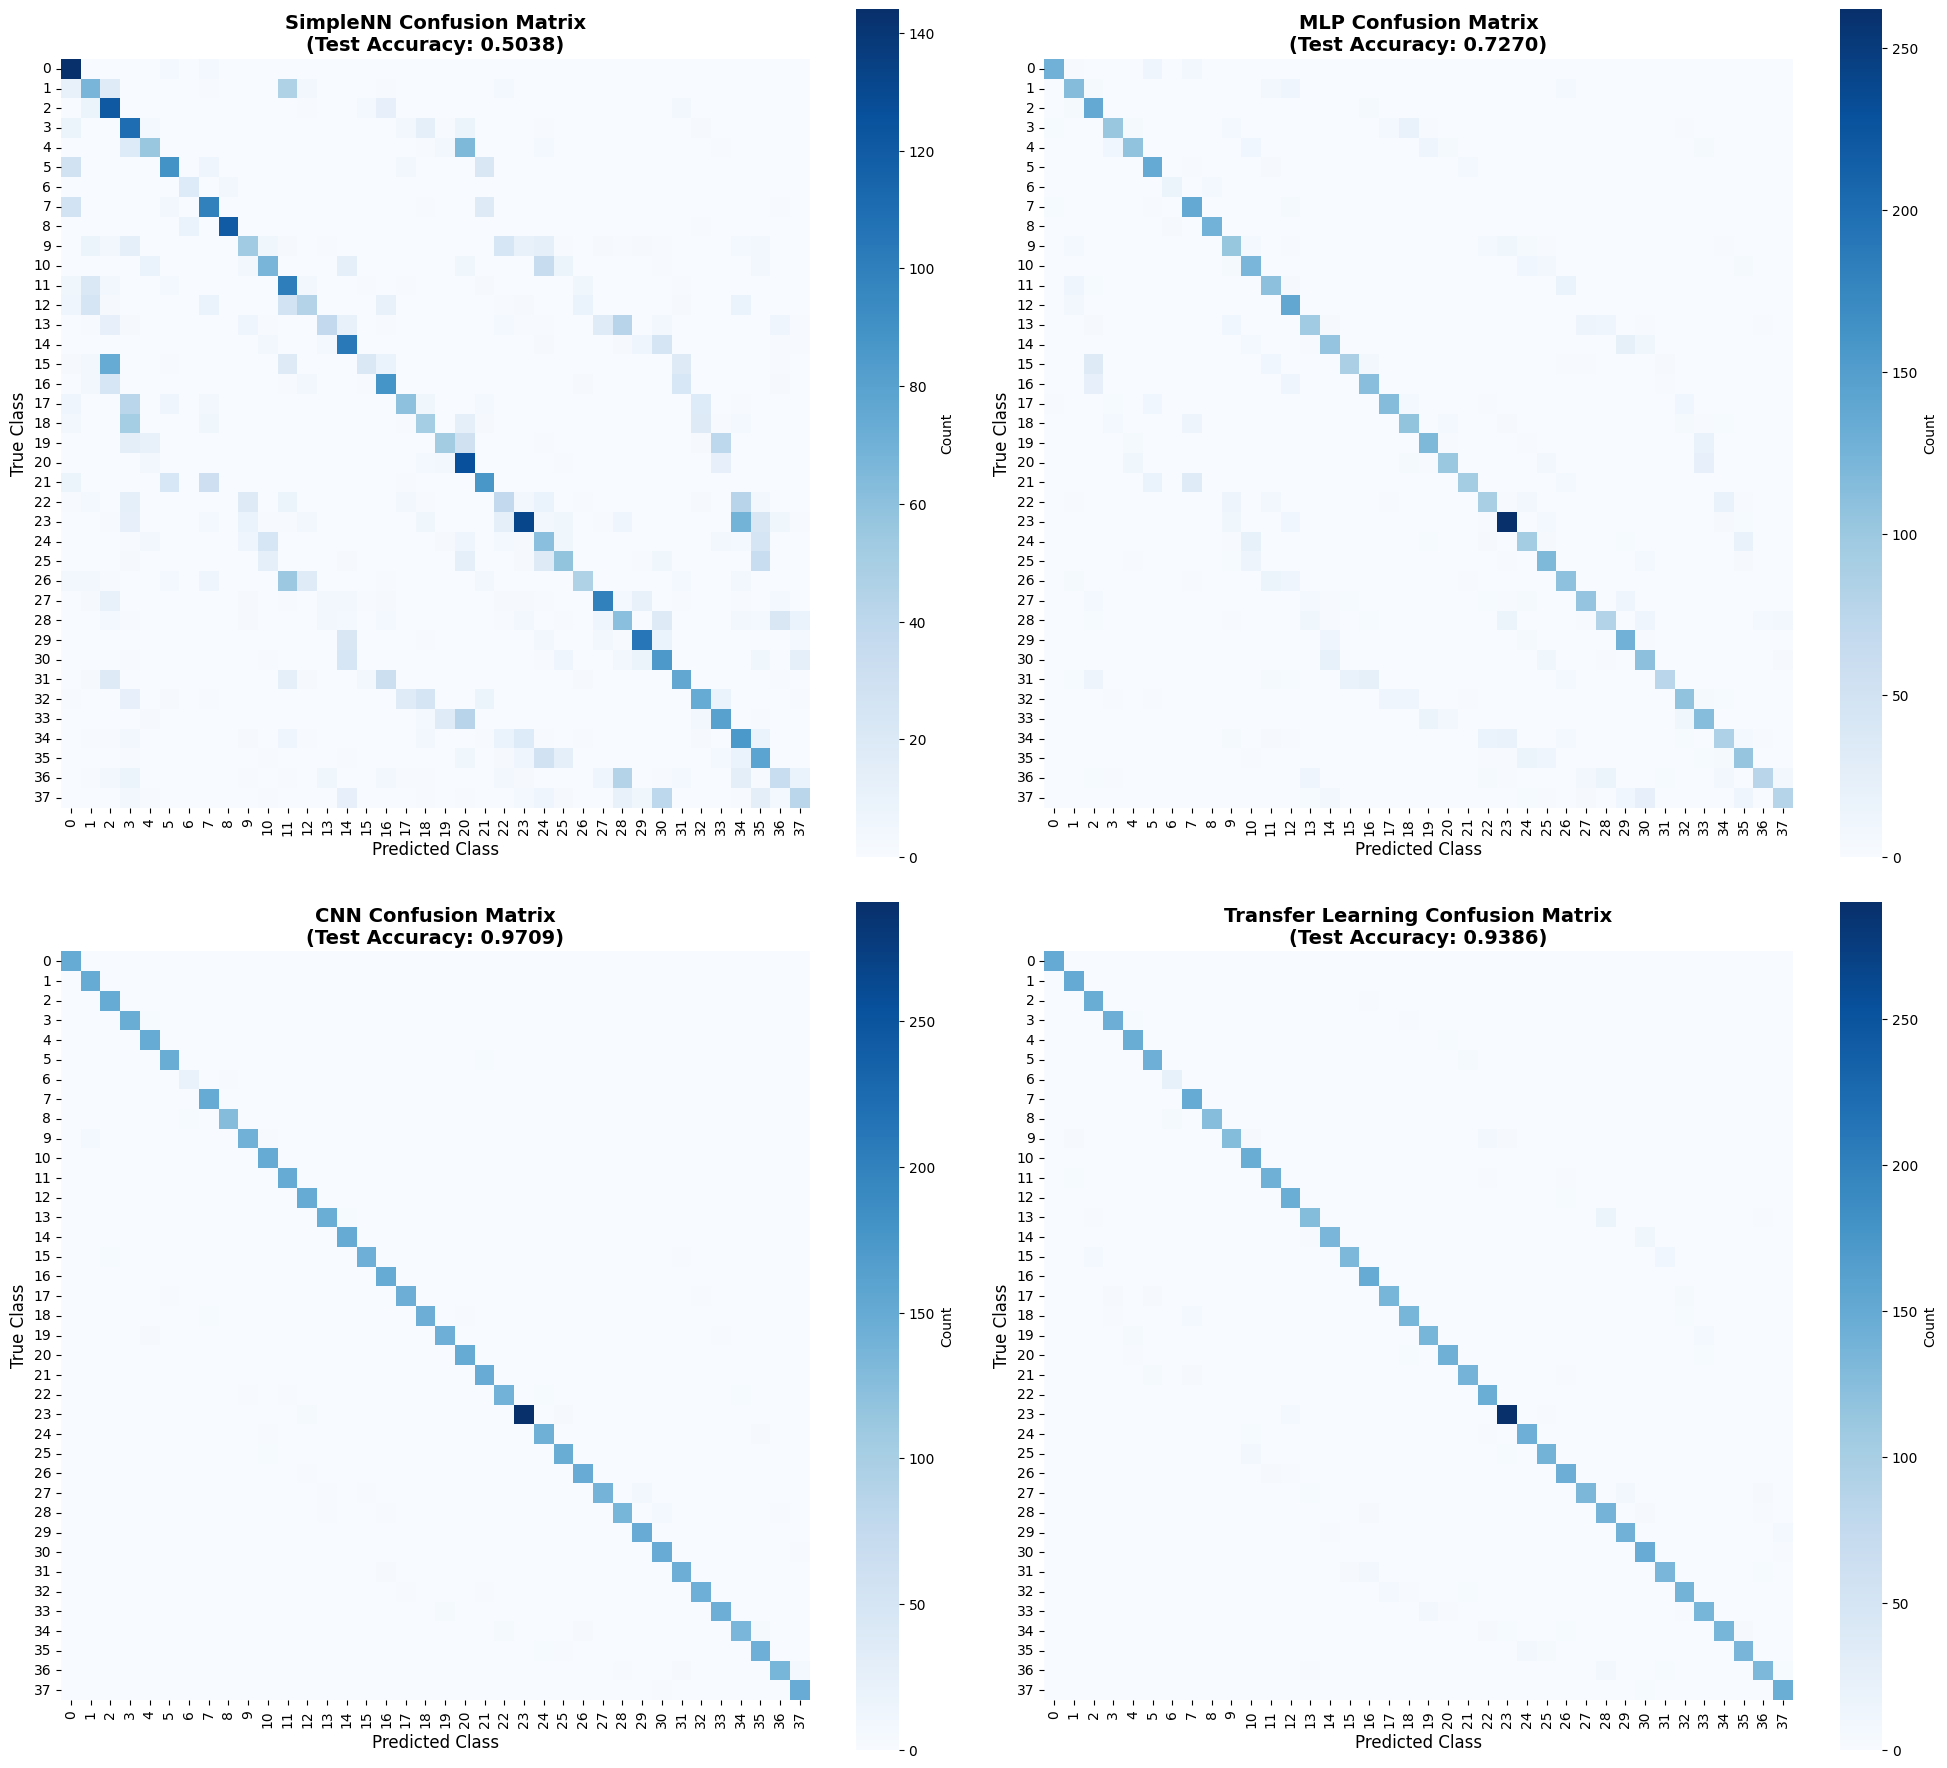

✓ Detailed confusion matrix saved as 'confusion_matrix_simplenn_detailed.png'
✓ Detailed confusion matrix saved as 'confusion_matrix_mlp_detailed.png'
✓ Detailed confusion matrix saved as 'confusion_matrix_cnn_detailed.png'
✓ Detailed confusion matrix saved as 'confusion_matrix_transfer_learning_detailed.png'


In [14]:
# Generate and visualize confusion matrices
print("\n" + "="*100)
print("CONFUSION MATRICES".center(100))
print("="*100 + "\n")

fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.flatten()

for idx, (model_name, predictions) in enumerate(all_predictions.items()):
    X_test, y_test_actual, _ = test_data_map[model_name]
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test_actual, predictions)
    
    # Plot
    ax = axes[idx]
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True, 
                ax=ax, cbar_kws={'label': 'Count'}, square=True)
    
    accuracy = accuracy_score(y_test_actual, predictions)
    ax.set_title(f'{model_name} Confusion Matrix\n(Test Accuracy: {accuracy:.4f})', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Class', fontsize=12)
    ax.set_ylabel('True Class', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrices plot saved as 'confusion_matrices_all_models.png'")
plt.show()

# Save individual high-resolution confusion matrices
for model_name, predictions in all_predictions.items():
    X_test, y_test_actual, _ = test_data_map[model_name]
    cm = confusion_matrix(y_test_actual, predictions)
    
    fig, ax = plt.subplots(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
                ax=ax, cbar_kws={'label': 'Count'}, square=True, 
                xticklabels=range(38), yticklabels=range(38))
    
    accuracy = accuracy_score(y_test_actual, predictions)
    plt.title(f'{model_name} - Detailed Confusion Matrix (Test Accuracy: {accuracy:.4f})',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Class', fontsize=14)
    plt.ylabel('True Class', fontsize=14)
    
    filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}_detailed.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✓ Detailed confusion matrix saved as '{filename}'")
    plt.close()

In [15]:
# Extract per-class metrics and create summary tables
from sklearn.metrics import precision_recall_fscore_support

print("\n" + "="*100)
print("PER-CLASS PERFORMANCE METRICS SUMMARY".center(100))
print("="*100 + "\n")

all_class_metrics = {}

for model_name, predictions in all_predictions.items():
    X_test, y_test_actual, _ = test_data_map[model_name]
    
    # Get precision, recall, f1, support for each class
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test_actual, predictions, average=None
    )
    
    # Create DataFrame
    class_metrics_df = pd.DataFrame({
        'Class': [f'Class_{i:02d}' for i in range(38)],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    all_class_metrics[model_name] = class_metrics_df
    
    print(f"\n{model_name.upper()}")
    print("-" * 100)
    print(class_metrics_df.to_string(index=False))
    print(f"\nMacro Avg - Precision: {precision.mean():.4f}, Recall: {recall.mean():.4f}, F1: {f1.mean():.4f}")
    print(f"Weighted Avg - Precision: {(precision * support / support.sum()).sum():.4f}, "
          f"Recall: {(recall * support / support.sum()).sum():.4f}, "
          f"F1: {(f1 * support / support.sum()).sum():.4f}")
    
    # Save to CSV
    csv_file = f'per_class_metrics_{model_name.lower().replace(" ", "_")}.csv'
    class_metrics_df.to_csv(csv_file, index=False)
    print(f"  ✓ Saved to: {csv_file}")


                               PER-CLASS PERFORMANCE METRICS SUMMARY                                


SIMPLENN
----------------------------------------------------------------------------------------------------
   Class  Precision   Recall  F1-Score  Support
Class_00   0.558140 0.960000  0.705882      150
Class_01   0.435065 0.446667  0.440789      150
Class_02   0.406040 0.806667  0.540179      150
Class_03   0.353698 0.733333  0.477223      150
Class_04   0.615385 0.373333  0.464730      150
Class_05   0.659259 0.593333  0.624561      150
Class_06   0.678571 0.826087  0.745098       23
Class_07   0.572254 0.660000  0.613003      150
Class_08   0.967742 0.923077  0.944882      130
Class_09   0.500000 0.353333  0.414062      150
Class_10   0.553719 0.446667  0.494465      150
Class_11   0.359431 0.673333  0.468677      150
Class_12   0.536585 0.293333  0.379310      150
Class_13   0.666667 0.253333  0.367150      150
Class_14   0.527919 0.693333  0.599424      150
Class_15   0.67741


✓ Per-class metrics comparison plot saved as 'per_class_metrics_comparison.png'


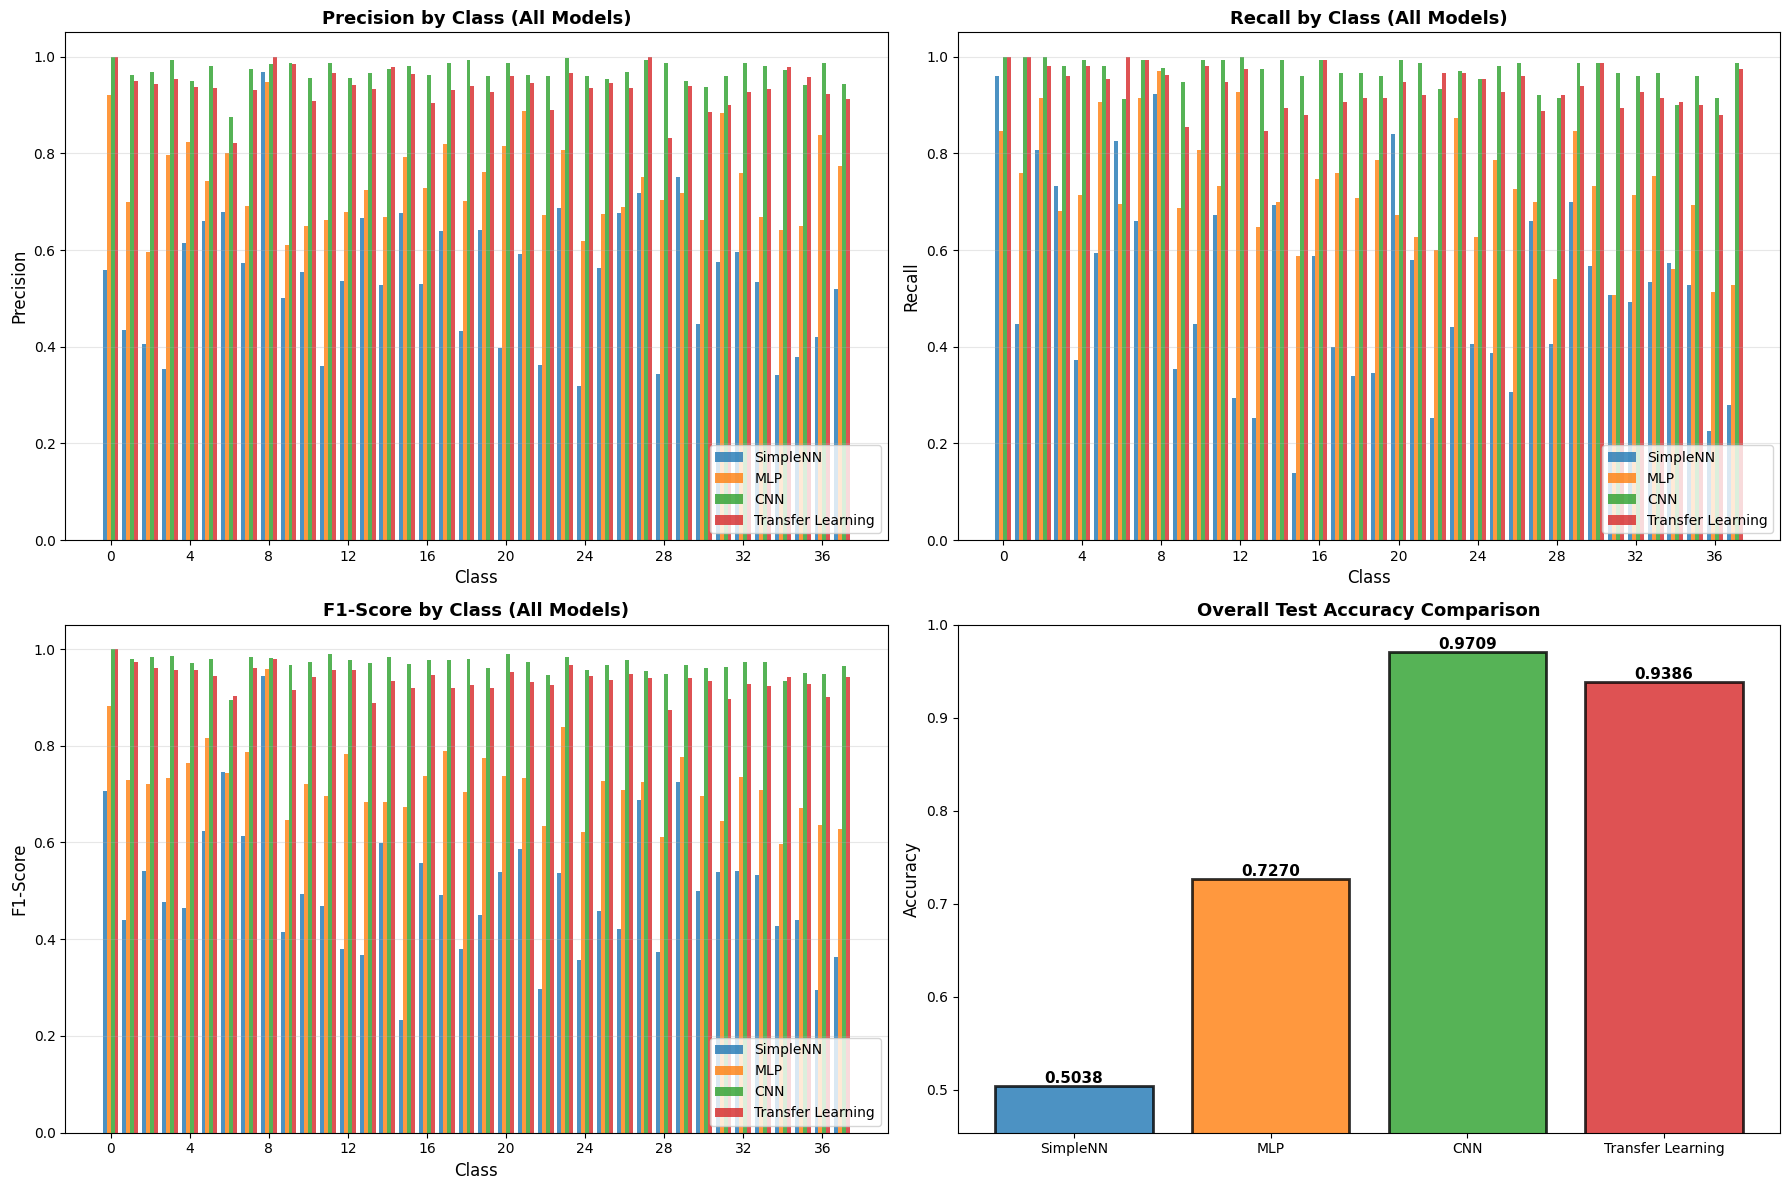

In [16]:
# Create comparison visualizations for class-wise metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

metrics = ['Precision', 'Recall', 'F1-Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for metric_idx, metric in enumerate(metrics):
    ax = axes[metric_idx]
    
    x = np.arange(38)
    width = 0.2
    
    for model_idx, (model_name, metrics_df) in enumerate(all_class_metrics.items()):
        values = metrics_df[metric].values
        ax.bar(x + (model_idx - 1.5) * width, values, width, 
               label=model_name, alpha=0.8, color=colors[model_idx])
    
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} by Class (All Models)', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.set_xticks(range(0, 38, 4))
    ax.grid(axis='y', alpha=0.3)

# Overall accuracy comparison in the 4th subplot
ax = axes[3]
model_names = list(all_class_metrics.keys())
accuracies = []
for model_name in model_names:
    preds = all_predictions[model_name]
    X_test, y_test_actual, _ = test_data_map[model_name]
    acc = accuracy_score(y_test_actual, preds)
    accuracies.append(acc)

bars = ax.bar(model_names, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Overall Test Accuracy Comparison', fontsize=13, fontweight='bold')
ax.set_ylim([min(accuracies) - 0.05, 1.0])

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('per_class_metrics_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Per-class metrics comparison plot saved as 'per_class_metrics_comparison.png'")
plt.show()

In [17]:
# Create comprehensive summary report
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
summary_report = {
    'timestamp': timestamp,
    'models_compared': list(all_predictions.keys()),
    'num_classes': 38,
    'test_set_size': len(y_test),
}

# Add accuracy and per-class metrics for each model
for model_name in all_predictions.keys():
    preds = all_predictions[model_name]
    X_test, y_test_actual, _ = test_data_map[model_name]
    
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test_actual, preds, average=None
    )
    
    summary_report[model_name] = {
        'test_accuracy': float(accuracy_score(y_test_actual, preds)),
        'macro_precision': float(precision.mean()),
        'macro_recall': float(recall.mean()),
        'macro_f1': float(f1.mean()),
        'weighted_precision': float((precision * support / support.sum()).sum()),
        'weighted_recall': float((recall * support / support.sum()).sum()),
        'weighted_f1': float((f1 * support / support.sum()).sum()),
    }

# Save comprehensive report
report_file = f'model_comparison_comprehensive_{timestamp}.json'
with open(report_file, 'w') as f:
    json.dump(summary_report, f, indent=4, default=str)
print(f"✓ Comprehensive report saved to: {report_file}")

# Create markdown summary
markdown_summary = "# Model Comparison: Classification Reports & Confusion Matrices\n\n"
markdown_summary += f"Generated: {timestamp}\n\n"

markdown_summary += "## Overall Performance Summary\n\n"
markdown_summary += "| Model | Test Accuracy | Macro F1 | Weighted F1 |\n"
markdown_summary += "|-------|---------------|----------|-------------|\n"

for model_name in all_predictions.keys():
    metrics = summary_report[model_name]
    markdown_summary += f"| {model_name} | {metrics['test_accuracy']:.4f} | {metrics['macro_f1']:.4f} | {metrics['weighted_f1']:.4f} |\n"

markdown_summary += "\n## Generated Files\n\n"
markdown_summary += "- **Classification Reports**: `classification_report_*.txt`\n"
markdown_summary += "- **Per-Class Metrics**: `per_class_metrics_*.csv`\n"
markdown_summary += "- **Confusion Matrices**: `confusion_matrix_*_detailed.png`\n"
markdown_summary += "- **Overall Comparison**: `confusion_matrices_all_models.png`\n"
markdown_summary += "- **Metrics Visualization**: `per_class_metrics_comparison.png`\n"
markdown_summary += "- **Comprehensive Report**: `model_comparison_comprehensive_*.json`\n"

md_file = f'model_comparison_summary_{timestamp}.md'
with open(md_file, 'w') as f:
    f.write(markdown_summary)
print(f"✓ Summary report saved to: {md_file}")

print("\n" + "="*100)
print("ANALYSIS COMPLETE".center(100))
print("="*100)
print("\nGenerated outputs:")
print(f"  - Classification reports (text)")
print(f"  - Per-class metrics (CSV)")
print(f"  - Confusion matrices (detailed PNG)")
print(f"  - Comparison visualizations (PNG)")
print(f"  - Comprehensive JSON report")
print(f"  - Markdown summary")

✓ Comprehensive report saved to: model_comparison_comprehensive_20251126_213153.json
✓ Summary report saved to: model_comparison_summary_20251126_213153.md

                                         ANALYSIS COMPLETE                                          

Generated outputs:
  - Classification reports (text)
  - Per-class metrics (CSV)
  - Confusion matrices (detailed PNG)
  - Comparison visualizations (PNG)
  - Comprehensive JSON report
  - Markdown summary


## 6. Model parameters vs accuracy

                                    MODEL PARAMETERS VS ACCURACY                                    

SimpleNN:
  Total Parameters: 102,790
  Trainable Parameters: 102,790
  Test Accuracy: 0.5038

MLP:
  Total Parameters: 730,278
  Trainable Parameters: 730,278
  Test Accuracy: 0.7270

CNN:
  Total Parameters: 1,310,822
  Trainable Parameters: 1,310,822
  Test Accuracy: 0.9709

Transfer Learning:
  Total Parameters: 11,196,006
  Trainable Parameters: 11,196,006
  Test Accuracy: 0.9386

✓ Plot saved as 'model_params_vs_accuracy.png'
✓ Plot saved as 'model_params_vs_accuracy.png'


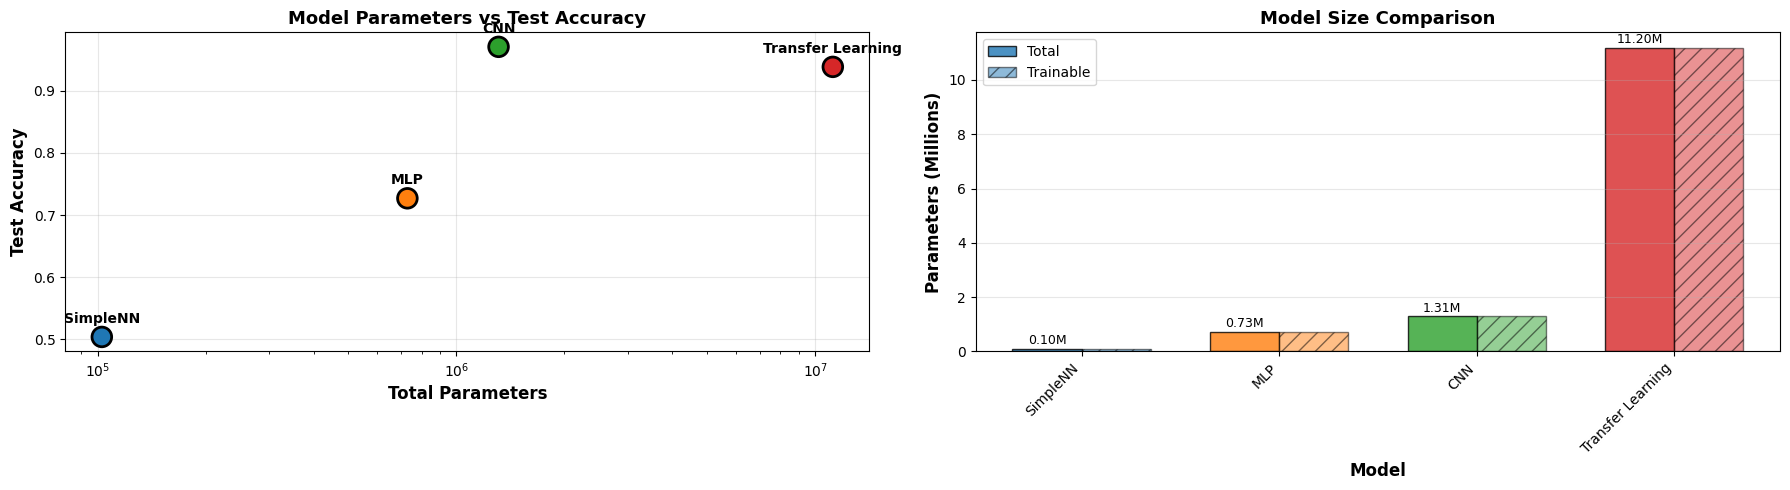


                                           SUMMARY TABLE                                            
            Model  Total Params  Trainable Params  Params (M)  Test Accuracy  Efficiency
              CNN       1310822           1310822    1.310822       0.970893    0.740675
Transfer Learning      11196006          11196006   11.196006       0.938629    0.083836
              MLP        730278            730278    0.730278       0.726986    0.995492
         SimpleNN        102790            102790    0.102790       0.503770    4.900963

🏆 Most Efficient Model: SimpleNN (Accuracy/Million Params: 4.901)


In [ ]:
# Model Parameters vs Accuracy Analysis
print("="*100)
print("MODEL PARAMETERS VS ACCURACY".center(100))
print("="*100 + "\n")

# Count parameters for each loaded model
def count_parameters(model):
    """Count total and trainable parameters"""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

model_stats = {}
for model_name, model in loaded_models.items():
    total_params, trainable_params = count_parameters(model)
    
    # Get test accuracy from predictions
    preds = all_predictions[model_name]
    X_test_data, y_test_actual, _ = test_data_map[model_name]
    test_acc = accuracy_score(y_test_actual, preds)
    
    model_stats[model_name] = {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'test_accuracy': test_acc
    }
    
    print(f"{model_name}:")
    print(f"  Total Parameters: {total_params:,}")
    print(f"  Trainable Parameters: {trainable_params:,}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print()

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

model_names = list(model_stats.keys())
total_params = [model_stats[m]['total_params'] for m in model_names]
trainable_params = [model_stats[m]['trainable_params'] for m in model_names]
accuracies = [model_stats[m]['test_accuracy'] for m in model_names]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(model_names)]

# Plot 1: Scatter plot - Parameters vs Accuracy
ax1 = axes[0]
scatter = ax1.scatter(total_params, accuracies, c=colors, s=200, edgecolors='black', linewidth=2, zorder=3)
for i, name in enumerate(model_names):
    ax1.annotate(name, (total_params[i], accuracies[i]), 
                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, fontweight='bold')
ax1.set_xlabel('Total Parameters', fontsize=12, fontweight='bold')
ax1.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Parameters vs Test Accuracy', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Plot 2: Bar chart - Parameters comparison
ax2 = axes[1]
x = np.arange(len(model_names))
width = 0.35
bars1 = ax2.bar(x - width/2, [p/1e6 for p in total_params], width, label='Total', color=colors, alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x + width/2, [p/1e6 for p in trainable_params], width, label='Trainable', color=colors, alpha=0.5, edgecolor='black', hatch='//')
ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_ylabel('Parameters (Millions)', fontsize=12, fontweight='bold')
ax2.set_title('Model Size Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax2.annotate(f'{height:.2f}M', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('model_params_vs_accuracy.png', dpi=300, bbox_inches='tight')
print("✓ Plot saved as 'model_params_vs_accuracy.png'")
plt.show()

# Summary Table
print("\n" + "="*100)
print("SUMMARY TABLE".center(100))
print("="*100)
summary_df = pd.DataFrame({
    'Model': model_names,
    'Total Params': total_params,
    'Trainable Params': trainable_params,
    'Params (M)': [p/1e6 for p in total_params],
    'Test Accuracy': accuracies,
}).sort_values('Test Accuracy', ascending=False)
print(summary_df.to_string(index=False))

## 7. Simple Saliency Maps for All 4 Models

In [30]:
# Simple Saliency Map Computation for All 4 Models
# Shows which pixels have the highest gradient with respect to class prediction

from sklearn.model_selection import StratifiedShuffleSplit

def compute_saliency_map(model, images, labels, device):
    """
    Compute saliency maps for neural network models.
    Shows which pixels are most important for the model's predictions.
    
    Args:
        model: PyTorch neural network model
        images: Input images tensor
        labels: True labels
        device: Device to compute on
    
    Returns:
        Saliency map (average importance across all images)
    """
    model.eval()
    
    # Convert to tensor if needed and ensure contiguous memory
    if not isinstance(images, torch.Tensor):
        images = torch.FloatTensor(images)
    
    # Ensure tensor is contiguous in memory
    images = images.contiguous().to(device)
    images.requires_grad = True
    
    # Forward pass
    outputs = model(images)
    
    # For each image, get the score of the true class
    scores = outputs.gather(1, torch.LongTensor(labels).to(device).unsqueeze(1))
    
    # Backward pass
    model.zero_grad()
    scores.sum().backward()
    
    # Get gradients (saliency)
    saliency = images.grad.data.abs()
    
    # Average across batch and flatten spatial dimensions
    if len(saliency.shape) == 4:  # CNN format (N, C, H, W)
        saliency = saliency.mean(dim=(0, 1)).cpu().numpy()  # Average over batch and channels
    else:  # MLP format (N, features)
        saliency = saliency.mean(dim=0).reshape(52, 52).cpu().numpy()
    
    return saliency

# =============================================================================
# STRATIFIED SAMPLING - Ensure all 38 classes are represented
# =============================================================================
print("="*80)
print("COMPUTING SALIENCY MAPS FOR ALL 4 MODELS".center(80))
print("="*80)

# Use stratified sampling to ensure all classes are represented
n_samples = min(5000, len(y_test))  # Use 500 samples or less if test set is smaller

# Create stratified split to get balanced class representation
sss = StratifiedShuffleSplit(n_splits=1, test_size=n_samples, random_state=42)

# Get stratified indices
for _, stratified_idx in sss.split(X_test_flat, y_test):
    pass  # Get the indices

# Prepare stratified test data for saliency computation
# Use .copy() to create contiguous arrays from indexed data
test_data_flat = torch.FloatTensor(X_test_flat[stratified_idx].copy())    # For SimpleNN/MLP
test_data_2d = torch.FloatTensor(X_test_2d[stratified_idx].copy())        # For CNN (N, 1, 52, 52)
test_data_3ch = torch.FloatTensor(X_test_3ch[stratified_idx].copy())      # For Transfer Learning (N, 3, 52, 52)
test_labels_subset = y_test[stratified_idx].copy()

# Verify stratification
unique_classes = np.unique(test_labels_subset)
print(f"\n✓ Using STRATIFIED sampling with {len(test_labels_subset)} samples")
print(f"✓ Classes represented: {len(unique_classes)}/38")
print(f"✓ Samples per class: ~{len(test_labels_subset)//len(unique_classes)}")
print("\nThis may take a minute...\n")

# Store saliency maps
saliency_results = {}

# Model 1: SimpleNN
print("Computing saliency for SimpleNN...")
try:
    saliency_simplenn = compute_saliency_map(
        loaded_models['SimpleNN'], test_data_flat, test_labels_subset, device
    )
    saliency_results['SimpleNN'] = saliency_simplenn
    print("  ✓ SimpleNN saliency computed")
except Exception as e:
    print(f"  ✗ SimpleNN error: {e}")
    saliency_results['SimpleNN'] = None

# Model 2: MLP
print("Computing saliency for MLP...")
try:
    saliency_mlp = compute_saliency_map(
        loaded_models['MLP'], test_data_flat, test_labels_subset, device
    )
    saliency_results['MLP'] = saliency_mlp
    print("  ✓ MLP saliency computed")
except Exception as e:
    print(f"  ✗ MLP error: {e}")
    saliency_results['MLP'] = None

# Model 3: CNN
print("Computing saliency for CNN...")
try:
    saliency_cnn = compute_saliency_map(
        loaded_models['CNN'], test_data_2d, test_labels_subset, device
    )
    saliency_results['CNN'] = saliency_cnn
    print("  ✓ CNN saliency computed")
except Exception as e:
    print(f"  ✗ CNN error: {e}")
    saliency_results['CNN'] = None

# Model 4: Transfer Learning
print("Computing saliency for Transfer Learning...")
try:
    saliency_transfer = compute_saliency_map(
        loaded_models['Transfer Learning'], test_data_3ch, test_labels_subset, device
    )
    saliency_results['Transfer Learning'] = saliency_transfer
    print("  ✓ Transfer Learning saliency computed")
except Exception as e:
    print(f"  ✗ Transfer Learning error: {e}")
    saliency_results['Transfer Learning'] = None

print("\n" + "="*80)
print("Saliency map computation complete!")
print(f"Successfully computed: {sum(1 for v in saliency_results.values() if v is not None)}/4 models")
print("="*80)

                    COMPUTING SALIENCY MAPS FOR ALL 4 MODELS                    

✓ Using STRATIFIED sampling with 5000 samples
✓ Classes represented: 38/38
✓ Samples per class: ~131

This may take a minute...

Computing saliency for SimpleNN...
  ✓ SimpleNN saliency computed
Computing saliency for MLP...

✓ Using STRATIFIED sampling with 5000 samples
✓ Classes represented: 38/38
✓ Samples per class: ~131

This may take a minute...

Computing saliency for SimpleNN...
  ✓ SimpleNN saliency computed
Computing saliency for MLP...
  ✓ MLP saliency computed
Computing saliency for CNN...
  ✓ MLP saliency computed
Computing saliency for CNN...
  ✓ CNN saliency computed
Computing saliency for Transfer Learning...
  ✓ CNN saliency computed
Computing saliency for Transfer Learning...
  ✓ Transfer Learning saliency computed

Saliency map computation complete!
Successfully computed: 4/4 models
  ✓ Transfer Learning saliency computed

Saliency map computation complete!
Successfully computed: 4/4 mo

                          SALIENCY MAPS VISUALIZATION                           

✓ Saliency maps saved as 'simple_saliency_maps_all_models.png'
✓ Saliency maps saved as 'simple_saliency_maps_all_models.png'


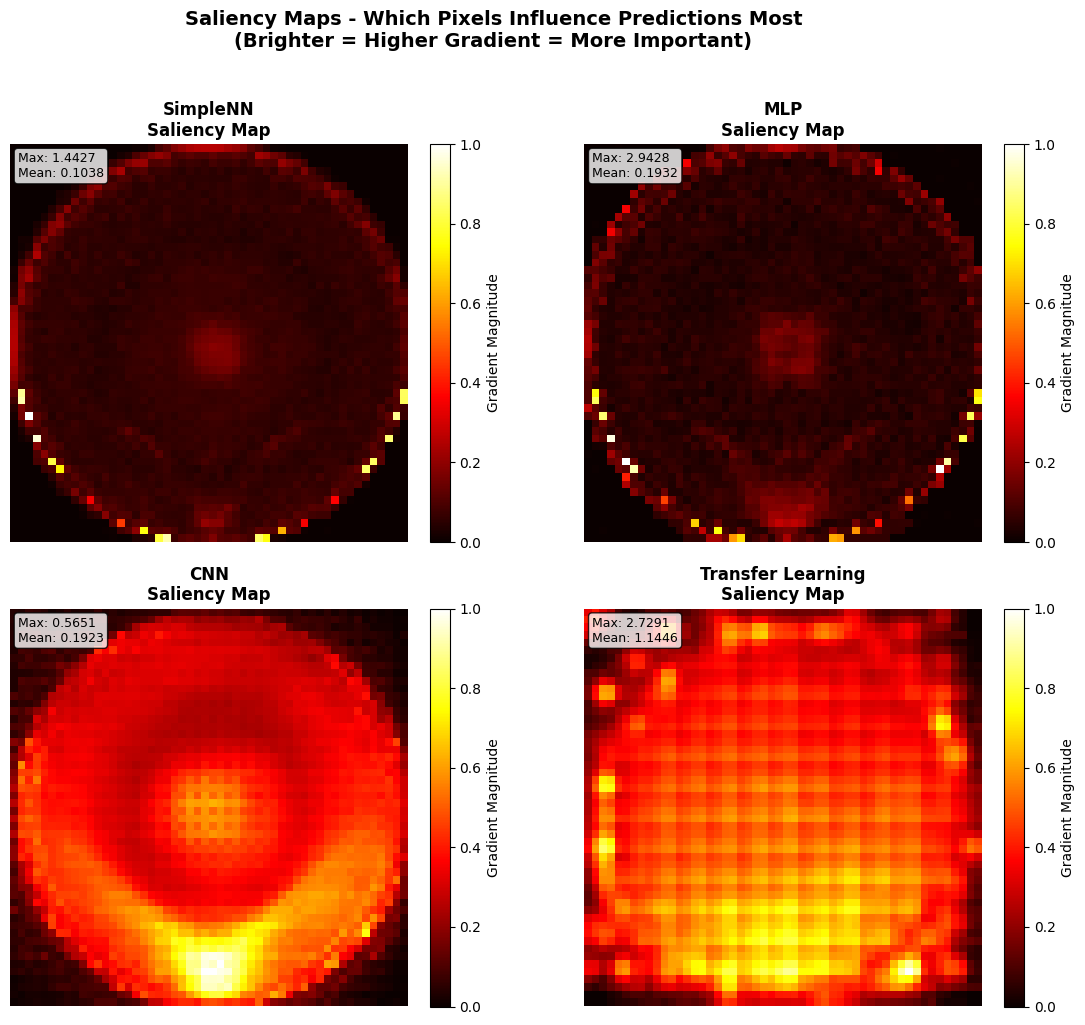


                              INTERPRETATION GUIDE                              

• Bright regions (yellow/white): High gradient magnitude - these pixels 
  strongly influence the model's prediction

• Dark regions (red/black): Low gradient magnitude - these pixels have 
  minimal impact on the prediction

• Pattern differences between models show how each architecture 
  "sees" the wafer defect patterns differently



In [31]:
# Visualize Saliency Maps for All 4 Models
print("="*80)
print("SALIENCY MAPS VISUALIZATION".center(80))
print("="*80 + "\n")

# Create figure with 2x2 grid for all 4 models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

model_names_order = ['SimpleNN', 'MLP', 'CNN', 'Transfer Learning']
cmaps = ['hot', 'hot', 'hot', 'hot']

for idx, model_name in enumerate(model_names_order):
    ax = axes[idx]
    saliency = saliency_results.get(model_name)
    
    if saliency is not None:
        # Normalize saliency for visualization
        saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
        
        im = ax.imshow(saliency_norm, cmap='hot', aspect='equal')
        ax.set_title(f'{model_name}\nSaliency Map', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Gradient Magnitude')
        
        # Add statistics
        ax.text(0.02, 0.98, f'Max: {saliency.max():.4f}\nMean: {saliency.mean():.4f}', 
                transform=ax.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.5, 0.5, f'{model_name}\n(Failed to compute)', 
                ha='center', va='center', fontsize=12, transform=ax.transAxes)
        ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    
    ax.axis('off')

fig.suptitle('Saliency Maps - Which Pixels Influence Predictions Most\n(Brighter = Higher Gradient = More Important)', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('simple_saliency_maps_all_models.png', dpi=300, bbox_inches='tight')
print("✓ Saliency maps saved as 'simple_saliency_maps_all_models.png'")
plt.show()

# Print interpretation
print("\n" + "="*80)
print("INTERPRETATION GUIDE".center(80))
print("="*80)
print("""
• Bright regions (yellow/white): High gradient magnitude - these pixels 
  strongly influence the model's prediction

• Dark regions (red/black): Low gradient magnitude - these pixels have 
  minimal impact on the prediction

• Pattern differences between models show how each architecture 
  "sees" the wafer defect patterns differently
""")